In [1]:
import sys
sys.path.append("../library")

In [2]:
from __future__ import print_function, division
import scipy
import pandas as pd
import math
import random
import numpy as np
from thinkbayes2 import Suite, Joint, Pmf, EvalNormalPdf, StandardNormalCdf, MakeCdfFromList, \
    Mean, Jitter, PmfProbGreater
import matplotlib.pyplot as plt
import thinkplot

# for reading data out
import brfss

# global sigmas number
NUM_SIGMAS = 1

In [3]:
def ReadHeights(nrows=None):
    """
    Read the BRFSS dataset, extract the heights and pickle them.
    nrows: number of rows to read
    """
    resp = brfss.ReadBrfss(nrows=nrows).dropna(subset=['sex', 'htm3'])
    groups = resp.groupby('sex')

    d = {}
    for name, group in groups:
        d[name] = group.htm3.values
    return d

In [4]:
def Summarize(xs):
    """
    Prints summary statistics from a sequence of values.
    xs: sequence of values
    """
    # print smallest and largest
    xs.sort()
    print('smallest', xs[:10])
    print('largest', xs[-10:])

    # print median and interquartile range
    cdf = MakeCdfFromList(xs)
    print(cdf.Percentile(25), cdf.Percentile(50), cdf.Percentile(75))

In [5]:
# refer to https://github.com/rlabbe/ThinkBayes2/blob/master/code/variability.py
class Height(Suite, Joint):
    """
    Analysis of height for men and women.
    """
    def __init__(self, mus, sigmas, label=None):
        """
        Construct [(mu, sigma)] for height gaussian distribution. Makes a prior distribution for mu and sigma based on a sample.
        mus: sequence of possible mus
        sigmas: sequence of possible sigmas
        label: string label for the Suite
        """
        pairs = [(mu, sigma) for mu in mus for sigma in sigmas]
        super().__init__(pairs, label=label)
    
    def Likelihood(self, data, hypo):
        """
        Computes the likelihood of the data under the hypothesis.
        Args:
            hypo: tuple of hypothetical mu and sigma
            data: float sample
        Returns:
            likelihood of the sample given mu and sigma
        """
        x = data
        mu, sigma = hypo
        like = EvalNormalPdf(x, mu, sigma)
        return like

In [6]:
def FindPriorRanges(xs, num_points, num_stderrs=3.0, median_flag=False):
    """
    Find ranges for mu and sigma with non-negligible likelihood.
    xs: sample
    num_points: number of values in each dimension
    num_stderrs: number of standard errors to include on either side
    
    Returns: sequence of mus, sequence of sigmas    
    """
    
    def MakeRange(estimate, stderr):
        """
        Makes a linear range around the estimate.
        estimate: central value
        stderr: standard error of the estimate
        returns: numpy array of float
        """
        spread = stderr * num_stderrs
        array = np.linspace(estimate-spread, estimate+spread, num_points)
        return array
    
    def MedianIPR(xs, p):
        """
        Computes the median and interpercentile range.
        xs: sequence of values
        p: range (0-1), 0.5 yields the interquartile range
        returns: tuple of float (median, IPR)
        """
        cdf = thinkbayes2.MakeCdfFromList(xs)
        median = cdf.Percentile(50)

        alpha = (1-p) / 2
        ipr = cdf.Value(1-alpha) - cdf.Value(alpha)
        return median, ipr
    
    def MedianS(xs, num_sigmas):
        """Computes the median and an estimate of sigma.
        Based on an interpercentile range (IPR).
        factor: number of standard deviations spanned by the IPR
        """
        half_p = StandardNormalCdf(num_sigmas) - 0.5
        median, ipr = MedianIPR(xs, half_p * 2)
        s = ipr / 2 / num_sigmas
        return median, s
    
    # estimate mean and stddev of xs
    n = len(xs)
    if median_flag:
        m, s = MedianS(xs, num_sigmas)
    else:
        m = np.mean(xs)
        s = np.std(xs)
    print('classical estimators: ', m, s)
    # compute ranges for m and s
    stderr_m = s / math.sqrt(n)
    mus = MakeRange(m, stderr_m)
    stderr_s = s / math.sqrt(2 * (n-1))
    sigmas = MakeRange(s, stderr_s)
    return mus, sigmas

In [7]:
def PlotCdfs(d, labels):
    """
    Plot CDFs for each sequence in a dictionary.
    Jitters the data and subtracts away the mean.
    d: map from key to sequence of values
    labels: map from key to string label
    """
    thinkplot.Clf()
    for key, xs in d.items():
        mu = Mean(xs)
        xs = Jitter(xs, 1.3)
        xs = [x-mu for x in xs]
        cdf = MakeCdfFromList(xs)
        # revise color of male to yellow, female to green
        thinkplot.Cdf(cdf, label=labels[key], color="C{}".format(key))
    thinkplot.Show()

In [8]:
def PlotPosterior(suite, pcolor=False, contour=True):
    """
    Makes a contour plot.
    
    suite: Suite that maps (mu, sigma) to probability
    """
    thinkplot.Clf()
    thinkplot.Contour(suite.GetDict(), pcolor=pcolor, contour=contour)
    thinkplot.Show()
#     thinkplot.Save(root='variability_posterior_%s' % suite.label,
#                 title='Posterior joint distribution',
#                 xlabel='Mean height (cm)',
#                 ylabel='Stddev (cm)')

In [9]:
def PlotCoefVariation(suites):
    """Plot the posterior distributions for CV.
    suites: map from label to Pmf of CVs.
    """
    thinkplot.Clf()
    thinkplot.PrePlot(num=2)

    pmfs = {}
    for label, suite in suites.items():
        pmf = CoefVariation(suite)
        print('CV posterior mean', pmf.Mean())
        cdf = MakeCdfFromPmf(pmf, label)
        thinkplot.Cdf(cdf)
        pmfs[label] = pmf

#     thinkplot.Save(root='variability_cv',
#                 xlabel='Coefficient of variation',
#                 ylabel='Probability')

    print('female bigger', PmfProbGreater(pmfs['female'], pmfs['male']))
    print('male bigger', PmfProbGreater(pmfs['male'], pmfs['female']))

In [10]:
def PlotMarginals(suite):
    """Plots marginal distributions from a joint distribution.
    suite: joint distribution of mu and sigma.
    """
    thinkplot.Clf()

    pyplot.subplot(1, 2, 1)
    pmf_m = suite.Marginal(0)
    cdf_m = MakeCdfFromPmf(pmf_m)
    thinkplot.Cdf(cdf_m)

    pyplot.subplot(1, 2, 2)
    pmf_s = suite.Marginal(1)
    cdf_s = MakeCdfFromPmf(pmf_s)
    thinkplot.Cdf(cdf_s)

    thinkplot.Show()

In [11]:
def RunEstimate(update_func, num_points=31, median_flag=False):
    """
    Runs the whole analysis.
    update_func: which of the update functions to use
    num_points: number of points in the Suite (in each dimension)
    """
    d = ReadHeights(nrows=None)
    labels = {1:'male', 2:'female'}
    PlotCdfs(d, labels)

    suites = {}
    for key, xs in d.items():
        label = labels[key]
        print(label, len(xs))
        Summarize(xs)

        xs = Jitter(xs, 1.3)

        mus, sigmas = FindPriorRanges(xs, num_points, median_flag=median_flag)
        suite = Height(mus, sigmas, label)
        suites[label] = suite
        update_func(suite, xs)
        print('MLE', suite.MaximumLikelihood())

        PlotPosterior(suite)

        pmf_m = suite.Marginal(0)
        pmf_s = suite.Marginal(1)
        print('marginal mu', pmf_m.Mean(), pmf_m.Var())
        print('marginal sigma', pmf_s.Mean(), pmf_s.Var())
        # PlotMarginals(suite)

    PlotCoefVariation(suites)

In [ ]:
def UpdateSuite1(suite, xs):
    """Computes the posterior distibution of mu and sigma.
    Computes untransformed likelihoods.
    suite: Suite that maps from (mu, sigma) to prob
    xs: sequence
    """
    suite.UpdateSet(xs)

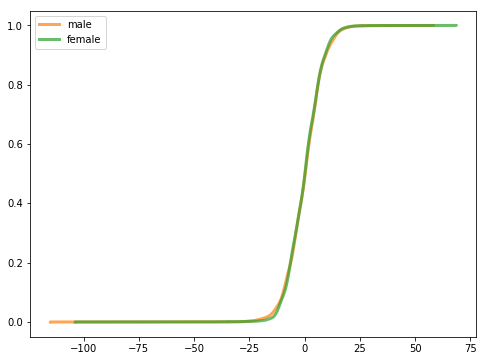

male 154407
smallest [ 61.  74.  76.  81.  86.  89.  89.  91.  97. 101.]
largest [218. 221. 221. 221. 221. 225. 226. 229. 229. 236.]
173.0 178.0 183.0
classical estimators:  178.06190657513923 7.831612618434213


In [ ]:
# Estimate 1: just using the same data
random.seed(17)
func = UpdateSuite1
median_flag = False
RunEstimate(func, median_flag=median_flag)